# Quantum GAN com Pennylane e MedMNIST

Este notebook apresenta uma implementação simplificada de uma GAN quântica inspirada no método de *patches* descrito por Huang et al. Utilizamos o dataset **MedMNIST** para comparação com os modelos clássicos.

## 1. Setup Quântico
Instalação de `pennylane` e demais bibliotecas necessárias para execução do modelo híbrido.

In [1]:
!pip install pennylane pennylane-lightning torch medmnist matplotlib --quiet
import torch
import pennylane as qml
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
import medmnist
from medmnist import INFO
import matplotlib.pyplot as plt

## 2. Preparação do Dataset
Utilizamos o mesmo subset do notebook clássico para permitir comparação direta. Pode ser necessário reduzir a resolução das imagens para se adequar ao número de qubits disponíveis.

In [2]:
# Seleciona o dataset
DATA_FLAG = 'breastmnist'
info = INFO[DATA_FLAG]
download = True

transform_lowres = transforms.Compose([
    transforms.Resize((8, 8)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

transform_highres = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Carrega treino e teste
train_dataset = getattr(medmnist, info['python_class'])(split='train', transform=transform_lowres, download=download)
test_dataset = getattr(medmnist, info['python_class'])(split='test', transform=transform_lowres, download=download)

train_dataset_highres = getattr(medmnist, info['python_class'])(split='train', transform=transform_highres, download=download)
test_dataset_highres = getattr(medmnist, info['python_class'])(split='test', transform=transform_highres, download=download)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


Using downloaded and verified file: /home/mahlow/.medmnist/breastmnist.npz
Using downloaded and verified file: /home/mahlow/.medmnist/breastmnist.npz
Using downloaded and verified file: /home/mahlow/.medmnist/breastmnist.npz
Using downloaded and verified file: /home/mahlow/.medmnist/breastmnist.npz


In [3]:
print(train_dataset)

Dataset BreastMNIST of size 28 (breastmnist)
    Number of datapoints: 546
    Root location: /home/mahlow/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 'normal, benign'}
    Number of samples: {'train': 546, 'val': 78, 'test': 156}
    Description: The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.
    License: CC BY 4.0


## 4. Treinamento
Configuração de modelos e funções para treinamento separado por classes.

In [4]:
import os
import math
import time

import numpy as np
import pennylane as qml
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# --- Hiperparâmetros ---
image_size    = 5      # tamanho do "patch"
batch_size    = 8      # tamanho do batch
pca_dims      = 40     # dimensão final (8 geradores x 5 qubits)
n_qubits      = 5      # número de qubits (e de features por gerador)
q_depth       = 6      # profundidade do circuito
n_generators  = 8      # quantos "patches" quânticos -> 40 dims

# --- Dispositivo GPU ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    torch.cuda.empty_cache()

# --- Função de escala para PCA ---
def scale_data(data, scale=None, dtype=np.float32):
    if scale is None:
        scale = [-1, 1]
    mn, mx = float(np.min(data)), float(np.max(data))
    a, b   = float(scale[0]), float(scale[1])
    return (((b - a) * (data - mn) / (mx - mn)) + a).astype(dtype)

# --- Pré-processamento (PCA) ---
base_imgs = train_dataset_highres.imgs if hasattr(train_dataset_highres, 'imgs') else train_dataset_highres.data
if isinstance(base_imgs, torch.Tensor):
    imgs_tensor = base_imgs.clone().float()
else:
    imgs_tensor = torch.tensor(base_imgs).float()

if imgs_tensor.ndim == 4 and imgs_tensor.shape[-1] == 1:
    imgs_tensor = imgs_tensor.permute(0, 3, 1, 2)
elif imgs_tensor.ndim == 3:
    imgs_tensor = imgs_tensor.unsqueeze(1)

if imgs_tensor.max() > 1:
    imgs_tensor = imgs_tensor / 255.0

lowres_tensor = F.interpolate(imgs_tensor, size=(8, 8), mode='bilinear', align_corners=False)
flat_imgs  = lowres_tensor.reshape(len(lowres_tensor), -1).cpu().numpy()
scaled     = scale_data(flat_imgs, [0, 1])
pca        = PCA(n_components=pca_dims)
pca_data   = pca.fit_transform(scaled)

# --- Circuito quântico ---
dev = qml.device('lightning.qubit', wires=n_qubits)

@qml.qnode(dev, interface='torch', diff_method='parameter-shift')
def quantum_circuit(noise, weights):
    weights = weights.reshape(q_depth, n_qubits)
    # codifica ruído
    for q in range(n_qubits):
        qml.RY(noise[q], wires=q)
        qml.RX(noise[q], wires=q)
    # camadas variacionais + emaranhamento
    for layer in range(q_depth):
        for q in range(n_qubits):
            qml.RY(weights[layer][q], wires=q)
        for q in range(n_qubits - 1):
            qml.CZ(wires=[q, q + 1])
    # retorna valor esperado de X em cada qubit
    return [qml.expval(qml.PauliX(q)) for q in range(n_qubits)]

# --- Modelos ---
class Discriminator(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(pca_dims,        hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,      hidden_dim // 4),
            nn.ReLU(),
            nn.Linear(hidden_dim // 4, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        return self.model(x)

class QuantumGenerator(nn.Module):
    def __init__(self, n_generators, q_delta=1.0):
        super().__init__()
        # mantenha os parâmetros quânticos em CPU, pois o simulação roda em CPU
        self.q_params = nn.ParameterList([
            nn.Parameter(q_delta * torch.rand(q_depth, n_qubits), requires_grad=True)
            for _ in range(n_generators)
        ])
        self.n_generators = n_generators

    def forward(self, x):
        batch_size = x.size(0)
        # saída final: batch_size x (n_generators * n_qubits) = batch_size x 40
        images = torch.zeros(batch_size, self.n_generators * n_qubits, device=device)

        for gen_idx, params in enumerate(self.q_params):
            # para cada amostra, roda o circuito (em CPU) e retorna CPU tensor
            patches = torch.stack([
                torch.tensor(
                    quantum_circuit(sample.cpu(), params.cpu()),
                    device=device
                ).float()
                for sample in x
            ], dim=0)  # shape (batch_size, n_qubits)

            start = gen_idx * n_qubits
            images[:, start:start + n_qubits] = patches

        return images


/home/mahlow/anaconda3/envs/my_env/lib/python3.11/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


### 4.1 Treinamento separado por classe
Treinamos dois geradores: um para imagens malignas (rótulo 0) e outro para imagens benignas (rótulo 1).

In [5]:
def train_quantum_gan(loader, G, D, epochs=50, device=None):
    """
    Treina o Quantum GAN usando dados de PCA vindos de `loader` (CPU, pin_memory=True)
    G e D já devem estar instanciados e enviados corretamente ao device.
    Retorna listas de histórico de loss do Discriminador e do Gerador.
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    criterion = nn.BCELoss()
    optD = optim.SGD(D.parameters(), lr=1e-2)
    optG = optim.SGD(G.parameters(), lr=3e-1)
    hist_D, hist_G = [], []

    total_start = time.time()
    for epoch in range(1, epochs + 1):
        epoch_start = time.time()
        running_D, running_G = 0.0, 0.0

        for real in loader:
            # real sai do DataLoader como tensor CPU pinned
            real = real.to(device, non_blocking=True)  # move para GPU
            b_size = real.size(0)

            # rótulos
            real_label = torch.ones((b_size, 1), device=device)
            fake_label = torch.zeros((b_size, 1), device=device)

            # gera amostras falsas
            noise = torch.rand(b_size, n_qubits, device=device) * (math.pi / 2)
            fake = G(noise)

            # --- Atualiza Discriminador ---
            optD.zero_grad()
            out_real = D(real)
            out_fake = D(fake.detach())
            loss_D = criterion(out_real, real_label) + criterion(out_fake, fake_label)
            loss_D.backward()
            optD.step()

            # --- Atualiza Gerador ---
            optG.zero_grad()
            out_fake = D(fake)
            loss_G = criterion(out_fake, real_label)
            loss_G.backward()
            optG.step()

            running_D += loss_D.item()
            running_G += loss_G.item()

        # calcula médias por batch
        hist_D.append(running_D / len(loader))
        hist_G.append(running_G / len(loader))
        epoch_time = time.time() - epoch_start
        print(f"Epoch {epoch}/{epochs}: D={hist_D[-1]:.4f}, G={hist_G[-1]:.4f} — {epoch_time:.2f}s")

    total_time = time.time() - total_start
    print(f"Training completed in {total_time:.2f}s")
    return hist_D, hist_G

# Exemplo de uso:


In [8]:
from torch.utils.data import DataLoader

# ——— Cria DataLoaders PCA por rótulo ———
# Extrai labels originais (pode ser .labels ou .targets)
labels = train_dataset.labels if hasattr(train_dataset, "labels") else train_dataset.targets

# Escala e converte o PCA já treinado (pca_data) para Tensor CPU
scaled_pca_np = scale_data(pca_data)                            # shape (N, 40)
tensor_pca     = torch.from_numpy(scaled_pca_np).float()        # Tensor CPU

# Índices para cada classe
idx0 = [i for i, l in enumerate(labels) if int(l) == 0]
idx1 = [i for i, l in enumerate(labels) if int(l) == 1]

# Subconjuntos PCA por rótulo
pca0 = tensor_pca[idx0]   # amostras “malignas”
pca1 = tensor_pca[idx1]   # amostras “benignas”

# DataLoaders com pin_memory para transferir rapidamente à GPU
loader_mal = DataLoader(pca0, batch_size=batch_size, shuffle=True,  drop_last=True, pin_memory=True)
loader_ben = DataLoader(pca1, batch_size=batch_size, shuffle=True,  drop_last=True, pin_memory=True)

# ——— Treina dois QGANs, um para cada classe ———
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Maligno (label 0)
G_mal = QuantumGenerator(n_generators).to(device)
D_mal = Discriminator().to(device)
hist_D_mal, hist_G_mal = train_quantum_gan(loader_mal, G_mal, D_mal, epochs=50, device=device)

# Benigno (label 1)
G_ben = QuantumGenerator(n_generators).to(device)
D_ben = Discriminator().to(device)
hist_D_ben, hist_G_ben = train_quantum_gan(loader_ben, G_ben, D_ben, epochs=50, device=device)


/tmp/ipykernel_735012/383101395.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  idx0 = [i for i, l in enumerate(labels) if int(l) == 0]
/tmp/ipykernel_735012/383101395.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  idx1 = [i for i, l in enumerate(labels) if int(l) == 1]


Epoch 1/50: D=1.3860, G=0.6659 — 16.85s
Epoch 2/50: D=1.3709, G=0.6789 — 17.82s
Epoch 3/50: D=1.3565, G=0.6911 — 17.56s
Epoch 4/50: D=1.3390, G=0.7065 — 17.65s
Epoch 5/50: D=1.3222, G=0.7202 — 17.86s
Epoch 6/50: D=1.2994, G=0.7393 — 18.14s
Epoch 7/50: D=1.2769, G=0.7574 — 18.07s
Epoch 8/50: D=1.2475, G=0.7829 — 17.82s
Epoch 9/50: D=1.2082, G=0.8193 — 17.87s
Epoch 10/50: D=1.1599, G=0.8668 — 18.11s
Epoch 11/50: D=1.1031, G=0.9258 — 17.41s
Epoch 12/50: D=1.0307, G=1.0128 — 17.72s
Epoch 13/50: D=0.9580, G=1.1070 — 17.97s
Epoch 14/50: D=0.8736, G=1.2333 — 17.83s
Epoch 15/50: D=0.7844, G=1.3860 — 15.41s
Epoch 16/50: D=0.6917, G=1.5674 — 18.01s
Epoch 17/50: D=0.5947, G=1.8094 — 15.95s
Epoch 18/50: D=0.5201, G=1.9894 — 15.14s
Epoch 19/50: D=0.4599, G=2.1258 — 15.11s
Epoch 20/50: D=0.3848, G=2.3932 — 15.09s
Epoch 21/50: D=0.3271, G=2.6043 — 15.05s
Epoch 22/50: D=0.2799, G=2.8045 — 15.77s
Epoch 23/50: D=0.2511, G=2.8732 — 15.14s
Epoch 24/50: D=0.2114, G=3.1460 — 15.15s
Epoch 25/50: D=0.1814, G=

### Curvas de Loss

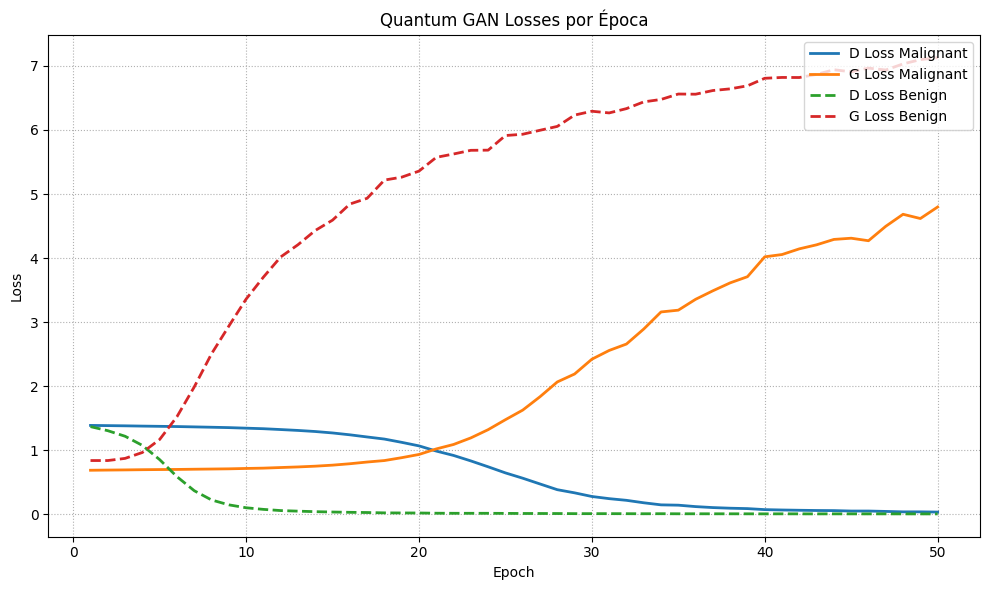

In [22]:
import matplotlib.pyplot as plt

# use “hist” porque é assim que você nomeou as listas retornadas
epochs = list(range(1, len(hist_D_mal) + 1))

plt.figure(figsize=(10, 6))
plt.plot(epochs, hist_D_mal, label='D Loss Malignant',     linewidth=2)
plt.plot(epochs, hist_G_mal, label='G Loss Malignant',     linewidth=2)
plt.plot(epochs, hist_D_ben, label='D Loss Benign',  linestyle='--', linewidth=2)
plt.plot(epochs, hist_G_ben, label='G Loss Benign',  linestyle='--', linewidth=2)

plt.title('Quantum GAN Losses por Época')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, linestyle=':')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


## 5. Avaliação
Utilize as mesmas métricas (FID e IS) para comparar as imagens geradas pela abordagem quântica.

In [10]:
def upscale_to_28(imgs, mode='bicubic'):
    return F.interpolate(imgs, size=(28, 28), mode=mode, align_corners=False)

In [13]:
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore
import math
from typing import Optional, Tuple
import pandas as pd

def _best_hw_from_F(F: int) -> Tuple[int, int]:
    # escolhe o par (h,w) de fatores de F com |h-w| mínimo
    best = None
    for h in range(1, int(math.sqrt(F)) + 1):
        if F % h == 0:
            w = F // h
            cand = (h, w)
            if best is None or abs(cand[0] - cand[1]) < abs(best[0] - best[1]):
                best = cand
    return best if best is not None else (1, F)

def to_4d_images(x: torch.Tensor, force_hw: Optional[Tuple[int,int]] = None) -> torch.Tensor:
    """
    Garante [N, C, H, W]. Suporta:
      - [N, C, H, W] -> passthrough
      - [N, H, W]    -> [N, 1, H, W]
      - [N, F]       -> reshape para [N, 1, H, W]
                       * se force_hw for dado, usa ele
                       * senão, fatora F e escolhe o par (H,W) mais 'quadrado'
    """
    if x.ndim == 4:
        return x
    if x.ndim == 3:
        return x.unsqueeze(1)  # [N,H,W] -> [N,1,H,W]
    if x.ndim == 2:
        n, F = x.shape
        if force_hw is not None:
            H, W = force_hw
            if H * W != F:
                raise ValueError(f"force_hw={force_hw} não casa com F={F}.")
        else:
            H, W = _best_hw_from_F(F)  # p.ex., 40 -> (5,8)
        return x.view(n, 1, H, W)
    raise ValueError(f"Shape {tuple(x.shape)} não suportado; esperado 2D/3D/4D.")

def normalize_to_01(x: torch.Tensor) -> torch.Tensor:
    with torch.no_grad():
        x_min, x_max = x.min(), x.max()
        # mapear [-1,1] -> [0,1] se parecer ser tanh
        if x_min >= -1.1 and x_max <= 1.1 and (x_min < 0 or x_max > 1):
            x = (x + 1) / 2
        return x.clamp(0, 1)

def evaluate_gan(
    G,
    label_target: int,
    gan_name: str,
    gen_label_name: str,
    test_dataset,
    n_qubits: int,
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu',
    max_batches: float = float('inf'),
    force_fake_hw: Optional[Tuple[int,int]] = None  # <<< NOVO
):
    loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    fid = FrechetInceptionDistance(feature=64, normalize=True).to(device)
    is_metric = InceptionScore(normalize=True).to(device)

    G = G.to(device).eval()

    count = 0
    for real, labels in loader:
        mask = (labels.squeeze() == label_target)
        if mask.sum() == 0:
            continue

        real = real[mask].to(device)        # [B,1,H,W] em [0,1]
        real = real.repeat(1, 3, 1, 1)
        real = F.interpolate(real, size=(299, 299), mode='bilinear', align_corners=False)

        b_size = real.size(0)
        noise = torch.rand(b_size, n_qubits, device=device) * (torch.pi / 2)

        with torch.no_grad():
            fake = G(noise)                           # possivelmente [B, F]
            fake = to_4d_images(fake, force_fake_hw)  # agora [B,1,H,W]
            fake = normalize_to_01(fake)
        fake = fake.to(device).repeat(1, 3, 1, 1)
        fake = F.interpolate(fake, size=(299, 299), mode='bilinear', align_corners=False)

        fid.update(real, real=True)
        fid.update(fake, real=False)
        is_metric.update(fake)

        count += 1
        if count >= max_batches:
            break

    fid_score = fid.compute().item()
    is_mean, is_std = is_metric.compute()
    return {
        'GAN': gan_name,
        'Generator_Label': gen_label_name,
        'Real_Label': 'Malignant' if label_target == 0 else 'Benign',
        'FID': fid_score,
        'IS_Mean': is_mean.item(),
        'IS_Std': is_std.item()
    }

results = []
results.append(evaluate_gan(G_mal, 0, 'QuantumGAN', 'Malignant',
                            test_dataset_highres, n_qubits,
                            force_fake_hw=(5,8)))  # força 5x8
results.append(evaluate_gan(G_ben, 1, 'QuantumGAN', 'Benign',
                            test_dataset_highres, n_qubits,
                            force_fake_hw=(5,8)))
results_df = pd.DataFrame(results)



In [14]:
results_df

,GAN,Generator_Label,Real_Label,FID,IS_Mean,IS_Std
0,QuantumGAN,Malignant,Malignant,5.416180,1.206290,0.138375
1,QuantumGAN,Benign,Benign,7.785486,1.247628,0.048824


## Classificação com ResNet

In [33]:
from torchvision.models import resnet18
import torch.nn.functional as F
from torch.utils.data import Dataset, ConcatDataset, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def custom_collate_fn(batch):
    xs, ys = zip(*batch)
    xs = torch.stack(xs, dim=0)
    ys_list = []
    for y in ys:
        if isinstance(y, torch.Tensor):
            val = y.item() if y.numel() == 1 else int(y.argmax().item())
        else:
            val = int(y)
        ys_list.append(val)
    ys = torch.tensor(ys_list, dtype=torch.long)
    return xs, ys

class SyntheticDataset(Dataset):
    def __init__(self, generator_dict, num_per_class, latent_dim, device=None):
        self.samples = []
        device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        for label_name, gen in generator_dict.items():
            label = 0 if label_name == 'malignant' else 1
            noise = torch.rand(num_per_class, n_qubits, device=device) * torch.pi/2
            with torch.no_grad():
                imgs = gen(noise).cpu()
                imgs = upscale_to_28(imgs)
            for img in imgs:
                self.samples.append((img, label))
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        return self.samples[idx]

def train_model(model, loader, epochs=5, device=None):
    device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    for _ in range(epochs):
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = F.cross_entropy(out, y)
            loss.backward()
            optimizer.step()

def evaluate(model, loader, device=None):
    device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            out = model(x)
            preds = out.argmax(dim=1).cpu()
            all_preds.append(preds)
            all_labels.append(y)
    y_true = torch.cat(all_labels).numpy()
    y_pred = torch.cat(all_preds).numpy()
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    try:
        auc = roc_auc_score(y_true, y_pred)
    except ValueError:
        auc = float('nan')
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return acc, prec, rec, f1, auc, tn, fp, fn, tp

def run_experiments(train_dataset, test_dataset, G_dict, batch_size=32, epochs=5, device=None):
    device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
    latent_dim = n_qubits
    ratios = [0.0, 0.25, 0.5, 0.75, 1.0, 1.5]
    results = []
    for r in ratios:
        if r == 0.0:
            ds = train_dataset
        else:
            num_syn = int(len(train_dataset) * r)
            syn_ds = SyntheticDataset(G_dict, num_syn // 2, latent_dim, device)
            ds = ConcatDataset([train_dataset, syn_ds])
        loader = DataLoader(ds, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
        model = resnet18(num_classes=2)
        model.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
        train_model(model, loader, epochs=epochs, device=device)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)
        acc, prec, rec, f1, auc, tn, fp, fn, tp = evaluate(model, test_loader, device=device)
        results.append({'ratio': r,'acc': acc,'prec': prec,'rec': rec,'f1': f1,'auc': auc,'tn': tn,'fp': fp,'fn': fn,'tp': tp})
    syn_only_ds = SyntheticDataset(G_dict, len(train_dataset)//2, latent_dim, device)
    syn_loader = DataLoader(syn_only_ds, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
    model = resnet18(num_classes=2)
    model.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
    train_model(model, syn_loader, epochs=epochs, device=device)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)
    acc, prec, rec, f1, auc, tn, fp, fn, tp = evaluate(model, test_loader, device=device)
    results.append({'ratio':'100%_sintético→real','acc':acc,'prec':prec,'rec':rec,'f1':f1,'auc':auc,'tn':tn,'fp':fp,'fn':fn,'tp':tp})
    total_syn = len(syn_only_ds)
    n_train = int(total_syn * 0.7)
    n_test = total_syn - n_train
    syn_train_ds, syn_test_ds = random_split(syn_only_ds, [n_train, n_test])
    train_loader = DataLoader(syn_train_ds, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
    test_loader = DataLoader(syn_test_ds, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)
    model = resnet18(num_classes=2)
    model.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
    train_model(model, train_loader, epochs=epochs, device=device)
    acc, prec, rec, f1, auc, tn, fp, fn, tp = evaluate(model, test_loader, device=device)
    results.append({'ratio':'100%_sintético_70/30_selftest','acc':acc,'prec':prec,'rec':rec,'f1':f1,'auc':auc,'tn':tn,'fp':fp,'fn':fn,'tp':tp})
    return pd.DataFrame(results)


In [34]:
G_dict = {'malignant': G_mal, 'benign': G_ben}
classification_results = run_experiments(train_dataset_highres, test_dataset_highres, G_dict, batch_size=64, epochs=5)
classification_results


/tmp/ipykernel_1207031/2515642927.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)
/tmp/ipykernel_1207031/2515642927.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)
/tmp/ipykernel_1207031/2515642927.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)
/tmp/ipykernel_1207031/2515642927.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract

,ratio,acc,prec,rec,f1,auc,tn,fp,fn,tp
0,0.0,0.801282,0.946237,0.771930,0.850242,0.826441,37,5,26,88
1,0.25,0.833333,0.860656,0.921053,0.889831,0.758145,25,17,9,105
2,0.5,0.865385,0.904348,0.912281,0.908297,0.825188,31,11,10,104
3,0.75,0.878205,0.905983,0.929825,0.917749,0.833960,31,11,8,106
4,1.0,0.782051,0.781690,0.973684,0.867188,0.617794,11,31,3,111
5,1.5,0.826923,0.899083,0.859649,0.878924,0.798872,31,11,16,98
6,100%_sintético→real,0.410256,0.703704,0.333333,0.452381,0.476190,26,16,76,38
7,100%_sintético_70/30_selftest,0.981707,0.968085,1.000000,0.983784,0.979452,70,3,0,91


In [35]:
# ========= Geração de classe 0 e montagem do dataset balanceado =========

class SyntheticDatasetClass0(Dataset):
    """
    Gera apenas classe 0 (malignant) a partir de G_class0.
    Assume que o gerador recebe 'noise' com shape compatível ao seu G (ex.: (N, n_qubits)).
    """
    def __init__(self, G_class0, num_samples, device=None):
        self.samples = []
        device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        G_class0 = G_class0.to(device).eval()

        # ruído uniforme [0, pi/2] como no seu código
        noise = torch.rand(num_samples, n_qubits, device=device) * torch.pi/2
        with torch.no_grad():
            imgs = G_class0(noise).cpu()
            imgs = upscale_to_28(imgs)   # usa sua função já existente

        for img in imgs:
            self.samples.append((img, 0))  # label 0 (malignant)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]


def build_balanced_train_dataset(train_dataset, G_class0, device=None):
    """
    Retorna um ConcatDataset onde a classe 0 é aumentada com sintéticos
    até igualar a quantidade da classe 1.
    """
    # conta exemplos por classe no dataset real
    counts = {0: 0, 1: 0}
    for i in range(len(train_dataset)):
        _, y = train_dataset[i]
        # aceita Tensor/intes; coerção leve
        if isinstance(y, torch.Tensor):
            yv = int(y.item()) if y.numel()==1 else int(y.argmax().item())
        else:
            yv = int(y)
        if yv in counts:
            counts[yv] += 1

    n0, n1 = counts[0], counts[1]
    # se classe 0 já for >= classe 1, não precisa gerar; caso contrário, gera o necessário
    add0 = max(0, n1 - n0)

    if add0 == 0:
        # já está balanceado (ou 0 é maioria). Aqui NÃO reduzimos classe 1.
        # (Se quiser, podemos aleatoriamente subamostrar a classe maior, mas não foi pedido.)
        return train_dataset, 0

    synth0 = SyntheticDatasetClass0(G_class0, add0, device=device)
    ds_bal = ConcatDataset([train_dataset, synth0])
    return ds_bal, add0


# ========= Execução balanceada: treino e avaliação =========

def run_experiments_balanced(
    train_dataset,
    test_dataset,
    G_class0,
    batch_size=32,
    epochs=5,
    device=None
):
    device = device or ('cuda' if torch.cuda.is_available() else 'cpu')

    # 1) treino com dataset REAL + sintéticos da classe 0 suficientes para balancear
    ds_bal, added0 = build_balanced_train_dataset(train_dataset, G_class0, device=device)
    loader_bal = DataLoader(ds_bal, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)

    model = resnet18(num_classes=2)
    model.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
    train_model(model, loader_bal, epochs=epochs, device=device)

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)
    acc, prec, rec, f1, auc, tn, fp, fn, tp = evaluate(model, test_loader, device=device)

    results = []
    results.append({
        'ratio': 'balanced',
        'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1, 'auc': auc,
        'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp,
        'added_class0_synth_total': int(added0)
    })

    # 2) 100% sintético → real (gera 50/50 por classe? Aqui só temos G_class0; então mantemos sua lógica: só sintético de 0)
    #    Para manter o espírito do seu pipeline, treinamos com 100% sintético de classe 0 e testamos no real.
    syn_only_ds = SyntheticDatasetClass0(G_class0, len(train_dataset)//2, device=device)
    syn_loader = DataLoader(syn_only_ds, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)

    model = resnet18(num_classes=2)
    model.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
    train_model(model, syn_loader, epochs=epochs, device=device)

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)
    acc, prec, rec, f1, auc, tn, fp, fn, tp = evaluate(model, test_loader, device=device)
    results.append({
        'ratio': '100%_sintético→real',
        'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1, 'auc': auc,
        'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp
    })

    # 3) 70/30 self-test (split no sintético de classe 0)
    total_syn = len(syn_only_ds)
    n_train = int(total_syn * 0.7)
    n_test  = total_syn - n_train

    syn_train_ds, syn_test_ds = random_split(syn_only_ds, [n_train, n_test])
    train_loader = DataLoader(syn_train_ds, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
    test_loader  = DataLoader(syn_test_ds,  batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

    model = resnet18(num_classes=2)
    model.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
    train_model(model, train_loader, epochs=epochs, device=device)
    acc, prec, rec, f1, auc, tn, fp, fn, tp = evaluate(model, test_loader, device=device)
    results.append({
        'ratio': '100%_sintético_70/30_selftest',
        'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1, 'auc': auc,
        'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp
    })

    return pd.DataFrame(results)


# ========= Exemplo de uso =========
# G_class0: gerador da classe 0 em .eval()
# Se você já tiver G_mal (malignant) e G_ben (benign), aqui usamos só o G_mal:
G_class0 = G_mal  # <- gerador da classe 0

classification_results_bal = run_experiments_balanced(
    train_dataset=train_dataset_highres,
    test_dataset=test_dataset_highres,
    G_class0=G_class0,
    batch_size=64,
    epochs=5,
    device=None
)

classification_results_bal


/tmp/ipykernel_1207031/3927998994.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yv = int(y)
/tmp/ipykernel_1207031/2515642927.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)
/tmp/ipykernel_1207031/2515642927.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)
/home/mahlow/anaconda3/envs/my_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. Fo

ValueError: not enough values to unpack (expected 4, got 1)